# Eddy strømmer i tynne ledere

Vi vet at et magnetisk felt som varierer i tid vil indusere strømmer i ledere. Hvis lederen er en ledningsløkke, vi det dannes en støm langsmed ledningen. Men hva skjer dersom en lederen har en viss utstrekning, f.eks. i form av et tynt metallpanel, slik du vil finne i en boks laget av et ledende metall? 

Dette skal vi se på i detalj her. Først ved å se på hva som skjer i et tynt, sirkulært ark, hvor vi kan løse problemet analytisk og så i en mer komplisert geometri, hvor vi må løse det med numeriske metoder. For å gjøre det, må vi innføre en ny numerisk metode som også kan være et nyttig verktøy i andre situasjoner.

## Strømmer i et tynt, sylindrisk ark

La oss først se på en forenklet situasjon hvor vi kan finne en analytisk løsning. Vi ser på at tynt ledende ark som er formet som en sirkel med radius $a$ og som ligger i $xy$-planet med sentrum i origo. Det er ut uniformt, tidsvarierende magnetisk felt hvor vi for enklelthetsskyld antar at

$$ \frac{\partial B_z}{\partial t} = B_0/\tau  \; .$$

Planen vår er å finne det elektriske feltet $\vec{E}$ i $xy$-planet og så bruke Ohms lov til å finne strømtettheten $\vec{J} = - \sigma \vec{E}$. Vi finner det elektriske feltet fra Faradays lov på differensial form:

$$\vec{\nabla } \times \vec{E} = - \frac{\partial \vec{B}}{\partial t}$$

Siden $\vec{B}$-feltet kun har en $z$-komponent, vil det kun være $z$-komponenten av curl'en til $\vec{E}$ som er forskellig fra null.

Fordi systemet er symmetrisk ved rotasjon om $z$-aksen (aksen gjennom sentrum av sirkelflaten), forventer vi også at $\vec{E}$-feltet har denne symmetrien. Vi benytter sylinderkoordinater og da er curl'en gitt som

$$\left( \vec{\nabla} \times \vec{E} \right)_z = \frac{1}{r}\left( \frac{\partial ( rE_{\phi} )}{\partial r} - \frac{\partial E_r}{\partial \phi} \right)$$

Fordi systemet har sylindrisk symmetri kan ikke $E_r$ avhenge av $\phi$. Dermed får vi

$$\frac{1}{r}\frac{\partial ( rE_{\phi})}{\partial r} = - \frac{\partial B_z}{\partial t}$$

Vi finner derfor at 

$$E_{\phi} = - \frac{1}{2} r \frac{\partial B_z}{\partial t}$$

Vi kan plotte dette ved å sette $\hat{\phi} = (-y,x)/r$ som gir

$$\vec{E} = - \frac{\partial B_z}{\partial t}(-y,x)$$

Vi plotter dette i følgende program

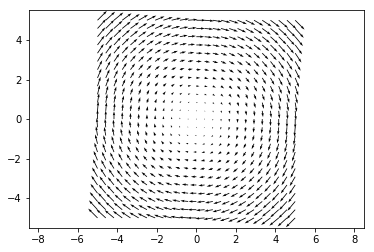

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
L=5
NL = 25
dBdt = 1.0
x = np.linspace(-L,L,NL)
y = np.linspace(-L,L,NL)
rx,ry = np.meshgrid(x,y)
Ex = -(dBdt/2)*(-ry)
Ey = -(dBdt/2)*(rx) 
plt.quiver(rx,ry,Ex,Ey)
plt.axis('equal')
plt.show()

# Numerisk løsning

Hvis systemet ikke har den fulle sylindriske symmetrien, hvordan kan vi da finne det elektriske feltet og/eller strømtettheten?

Først, la oss anta at vi kan se bort fra magnetfeltet som dannes av strømmene i systemet vårt. Dvs. vi antar at det ytre feltet er mye sterkere enn strømmene som settes opp av strømtettheten vi finner.

I dette tilfellet skal vi løse

$$\vec{\nabla } \times \vec{E} = - \frac{\partial \vec{B}}{\partial t}$$
 
Hvor vi samtidig vet at $\nabla \cdot \vec{J} = 0$ og at $\vec{E} = \rho \vec{J}$ hvor $\rho = 1/\sigma$ her er resistiviteten i materialet (og ikke ladningstettheten).

Vi vet da at vi kan uttrykke $\vec{J}$ med et vektorpotensial $\vec{J} = \nabla \times \vec{T}$. Fordi vi ser på et tynt ark har ikke $\vec{J}$ en $z$-komponent, og $\vec{T} = T(x,y) \hat{\vec{z}}$.

Da er

$$\vec{J} = \frac{\partial T}{\partial y}\hat{x} - \frac{\partial T}{\partial x}\hat{y}$$  

Det betyr igjen at $\vec{E} = \rho \nabla \times \vec{T}$ som satt inn ovenfor gir

$$\nabla \times \vec{E} = \nabla \times \left( \rho \nabla \times \vec{T}\right) = - \frac{\partial \vec{B}}{\partial t}$$

Hvis $\rho$ er konstant, blir dette $\nabla \times \left(\nabla \times \vec{T}\right)$. Vi bruker en vektor-relasjon som er $\nabla \times \left(\nabla \times \vec{T}\right) = \nabla \left( \nabla \cdot \vec{T} \right) - \nabla^2 \vec{T}$. Merk at her er  $\nabla \cdot \vec{T} = 0$ fordi $\vec{T}$ kun har en $z$-komponent og denne ikke avhenger av $z$ ($\vec{T} = T(x,y)\hat{z}$).

Dermed har vi endt opp med Poissons liking for $T(x,y)$:

$$\nabla^2 T = + \frac{\partial B_z}{\partial t}$$

Denne vet vi hvordan vi skal løse!

__Men hva er randbetingelsene?__ Vi vet at det ikke kan være noe strøm ut av systemet slik at $\vec{J} \cdot \hat{n} = 0$ på randen. Uttrykt i form av $T$ betyr det at $T$ er konstant langsmed randen. (Fordi den tangentielt deriverte av $T$ er null).

Da har vi både en likning vi skal løse og randbetingelser. Vi gjør om vår gamle løser for Laplace likning til å løse Poissons likning.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [4]:
@jit(cache=True)
def solveeddy(b,nrep,Bf):
    """ b = boundary conditions
    nrep = number of iterations
    Bf = time derivative of flux of B-field
    returns potentials """
    V = np.copy(b)
    for i in range(len(V.flat)):
        if (np.isnan(b.flat[i])):
            V.flat[i] = 0.0
    Vnew = np.copy(V)
    Lx = b.shape[0]
    Ly = b.shape[1]
    for n in range(nrep):
        for ix in range(Lx):
            for iy in range(Ly):
                if (np.isnan(b[ix,iy])):
                    Vnew[ix,iy] = (V[ix+1,iy]+V[ix-1,iy]+V[ix,iy+1]+V[ix,iy-1]-Bf[ix,iy])/4
        V, Vnew = Vnew, V # Swap pointers to arrays
    return V

In [5]:
# Make boundaries
Lx = 20
Ly = 40
b = np.zeros((Lx,Ly),float)
b[:] = np.float('nan')

b[0,:] = 0.0
b[Lx-1,:] = 0.0
b[:,0] = 0.0
b[:,Ly-1] = 0.0

In [6]:
# Generate driving time derivative of flux of magnetic field
bfield = np.ones((Lx,Ly),float)

In [7]:
nrep = 1000000
T = solveeddy(b,nrep,bfield)

In [8]:
def findJ(T):
    Lx = T.shape[0]
    Ly = T.shape[1]
    Jx = np.copy(T)
    for i in range(len(T.flat)):
            Jx.flat[i] = 0.0
    Jy = np.copy(T)
    for i in range(len(T.flat)):
            Jy.flat[i] = 0.0
    for ix in range(1,Lx-1):
        for iy in range(1,Ly-1):
            Jx[ix,iy] = (T[ix,iy+1]-T[ix,iy])
            Jy[ix,iy] = -(T[ix+1,iy]-T[ix,iy])
    return Jx,Jy    

In [9]:
Jy,Jx = findJ(T)

(-1.9500000000000002, 40.95, -0.9500000000000001, 19.95)

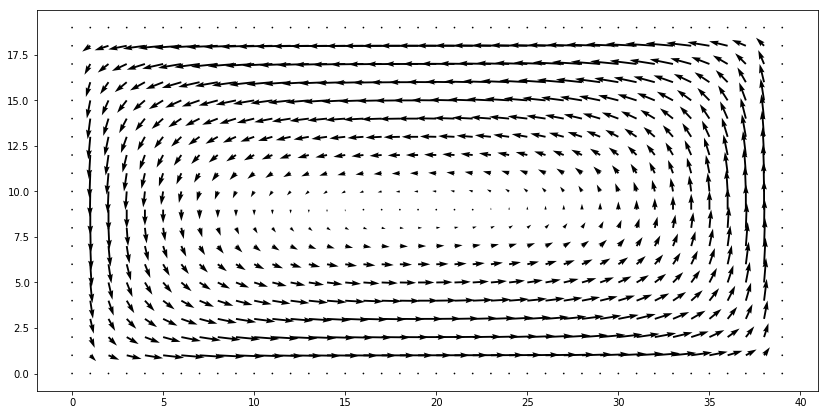

In [10]:
plt.figure(figsize=(14,7))
plt.quiver(Jx,Jy)
plt.axis('equal')

(0.0, 39.0, 0.0, 19.0)

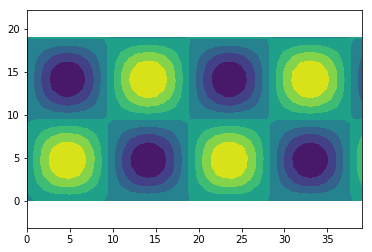

In [11]:
# Generate a field with more details
x = np.linspace(0,Lx-1,Lx)
y = np.linspace(0,Ly-1,Ly)
rx,ry = np.meshgrid(x,y)
bb = np.sin(rx/3)*np.sin(ry/3)

plt.contourf(bb.T)
plt.axis('equal')

In [12]:
nrep = 1000000
T2 = solveeddy(b,nrep,bb)
J2y,J2x = findJ(T2)

(-1.9500000000000002, 40.95, -0.9500000000000001, 19.95)

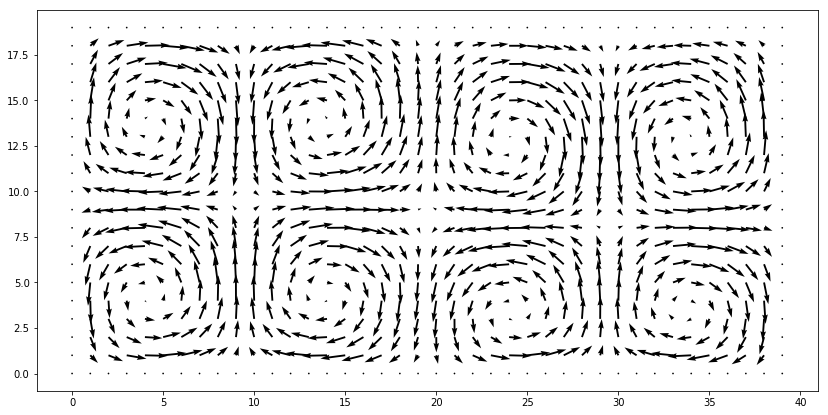

In [13]:
plt.figure(figsize=(14,7))
plt.quiver(J2x,J2y)
plt.axis('equal')

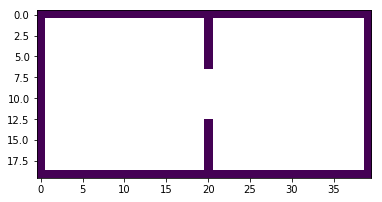

In [14]:
# Generate more complex boundary conditions
# Make boundaries
Lx = 20
Ly = 40
b = np.zeros((Lx,Ly),float)
b[:] = np.float('nan')

b[0,:] = 0.0
b[Lx-1,:] = 0.0
b[:,0] = 0.0
b[:,Ly-1] = 0.0

c = 0.35
b[0:int(Lx*c),int(Ly/2)] = 0.0
b[int(Lx*(1-c)):,int(Ly/2)] = 0.0

plt.imshow(b)

In [15]:
nrep = 1000000
bfield = np.ones((Lx,Ly),float)
T = solveeddy(b,nrep,bfield)
Jy,Jx = findJ(T)

(-1.9500000000000002, 40.95, -0.9500000000000001, 19.95)

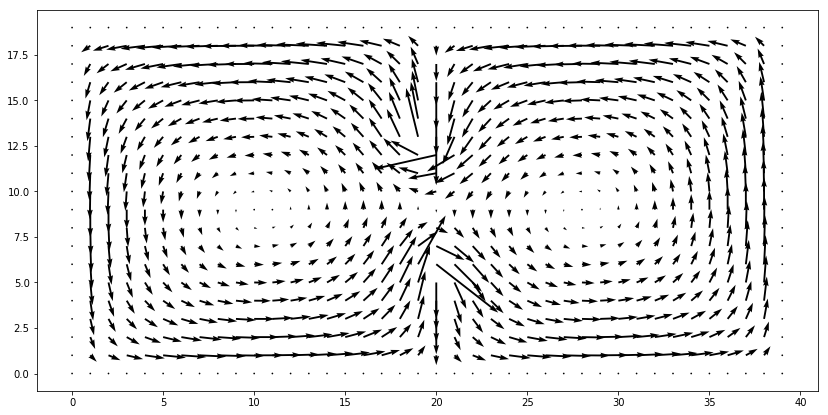

In [16]:
plt.figure(figsize=(14,7))
plt.quiver(Jx,Jy)
plt.axis('equal')